In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [2]:
# load Zambia shapefile
zambia_fp = '/home/h99g576/zambia/Data/district.shp'
zambia_gdf = gpd.read_file(zambia_fp)
zambia_gdf.set_crs(epsg=4326, inplace=True)

# load survey data
df = pd.read_csv('/home/h99g576/zambia/Data/Charc.csv')

ERROR 1: PROJ: proj_create_from_database: Open of /mnt/shared/moduleapps/EarthSci/Python-3.9.15-Mamba/share/proj failed


In [3]:
# convert to geodataframe
charcoal_gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.longitude, df.latitude),
    crs='EPSG:4326'
)

In [4]:
zambia_gdf = zambia_gdf.rename(columns={'NAME_2': 'district'})
zambia_gdf['district'] = zambia_gdf['district'].str.strip().str.title()

In [5]:
# charcoal production counts by district
charcoal_counts = (
    df.groupby('district')['Charc']
    .apply(lambda x: (x == 1).sum())
    .reset_index(name='charcoal')
)

# merge with shapefile
zambia_merged = zambia_gdf.merge(charcoal_counts, on='district', how='left')
zambia_merged['charcoal'] = zambia_merged['charcoal'].fillna(0)

# filter only charcoal production districts
charcoal_with_points = zambia_merged[zambia_merged['charcoal'] > 0].copy()

# project to UTM
charcoal_with_points_utm = charcoal_with_points.to_crs(epsg=32735)

# calculate centroids
charcoal_with_points_utm['centroid'] = charcoal_with_points_utm.geometry.centroid

# convert back
charcoal_with_points_latlon = charcoal_with_points_utm.set_geometry('centroid').to_crs(epsg=4326)

In [6]:
charcoal_points = gpd.GeoDataFrame(
    charcoal_with_points_utm[['district', 'charcoal']].copy(),
    geometry=charcoal_with_points_utm['centroid'],
    crs=charcoal_with_points_utm.crs 
)

charcoal_points = charcoal_points.to_crs(epsg=4326)

In [37]:
# Load urban proximity CSV
urban_dist = pd.read_csv('/home/h99g576/zambia/final/urban_proximity.csv')

# Prepare charcoal counts
charcoal_counts.rename(columns={'charcoal': 'charcoal_count'}, inplace=True)

charcoal_counts

,district,charcoal_count
0,Choma,26
1,Lundazi,3
2,Masaiti,51
3,Mbala,9
4,Mkushi,38
5,Mpongwe,25
6,Mufumbwe,14
7,Mumbwa,18
8,Mungwi,34
9,Namwala,21


In [7]:
# add buffers
charcoal_points_utm = charcoal_points.to_crs(epsg=32735)
zambia_gdf_utm = zambia_gdf.to_crs(epsg=32735)

# create 25 and 50 km buffers (in meters)
buffer_25km = charcoal_points_utm.buffer(25000)
buffer_50km = charcoal_points_utm.buffer(50000)

# convert buffers to geodataframes
buffer_25km_gdf = gpd.GeoDataFrame(geometry=buffer_25km, crs=charcoal_points_utm.crs)
buffer_50km_gdf = gpd.GeoDataFrame(geometry=buffer_50km, crs=charcoal_points_utm.crs)

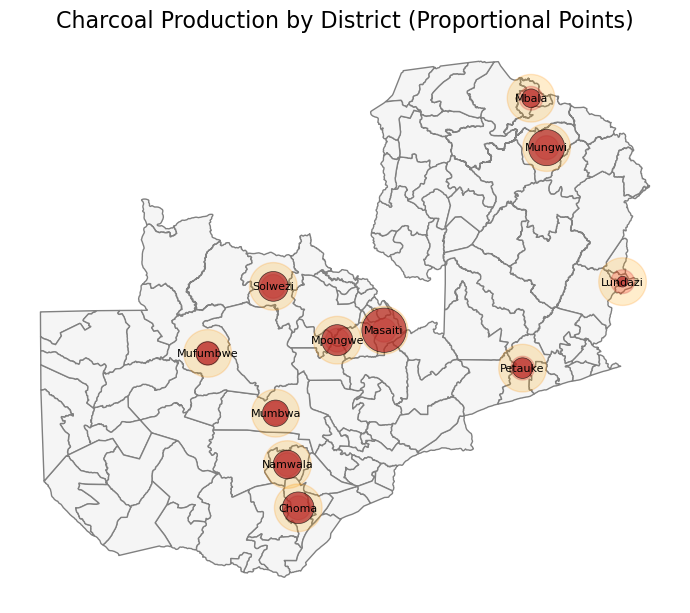

In [13]:
fig, ax = plt.subplots(figsize=(7, 12))

# Base Zambia map (optional: gray all districts, or use only charcoal ones)
zambia_gdf_utm.plot(ax=ax, color='whitesmoke', edgecolor='gray')

# plot 50km buffer
buffer_50km_gdf.plot(ax=ax, color='orange', alpha=0.2, edgecolor='darkorange')

buffer_25km_gdf.plot(ax=ax, color='red', alpha=0.2, edgecolor='firebrick')

# Proportional charcoal points
charcoal_points_utm.plot(
    ax=ax,
    markersize=charcoal_points['charcoal'] * 20,  # adjust scale factor as needed
    color='firebrick',
    alpha=0.7,
    edgecolor='black',
    linewidth=0.5
)

# label districts
for idx, row in charcoal_points_utm.iterrows():
    ax.text(
        row.geometry.x,
        row.geometry.y,
        row['district'],
        fontsize=8,
        ha='center',
        va='center',
        color='black'
    )
    
ax.set_title('Charcoal Production by District (Proportional Points)', fontsize=16)
ax.set_axis_off()
plt.tight_layout()
plt.show()